In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, SeasonalNaive)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2019-01-01', end='2023-12-31', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,ds,unique_id,y
0,2019-01-03,AAPL,-0.104924
1,2019-01-04,AAPL,0.041803
2,2019-01-08,AAPL,0.018884
3,2019-01-09,AAPL,0.016839
4,2019-01-10,AAPL,0.003191
...,...,...,...
8735,2023-12-21,NVDA,0.018105
8736,2023-12-22,NVDA,-0.003271
8737,2023-12-27,NVDA,0.002796
8738,2023-12-28,NVDA,0.002123


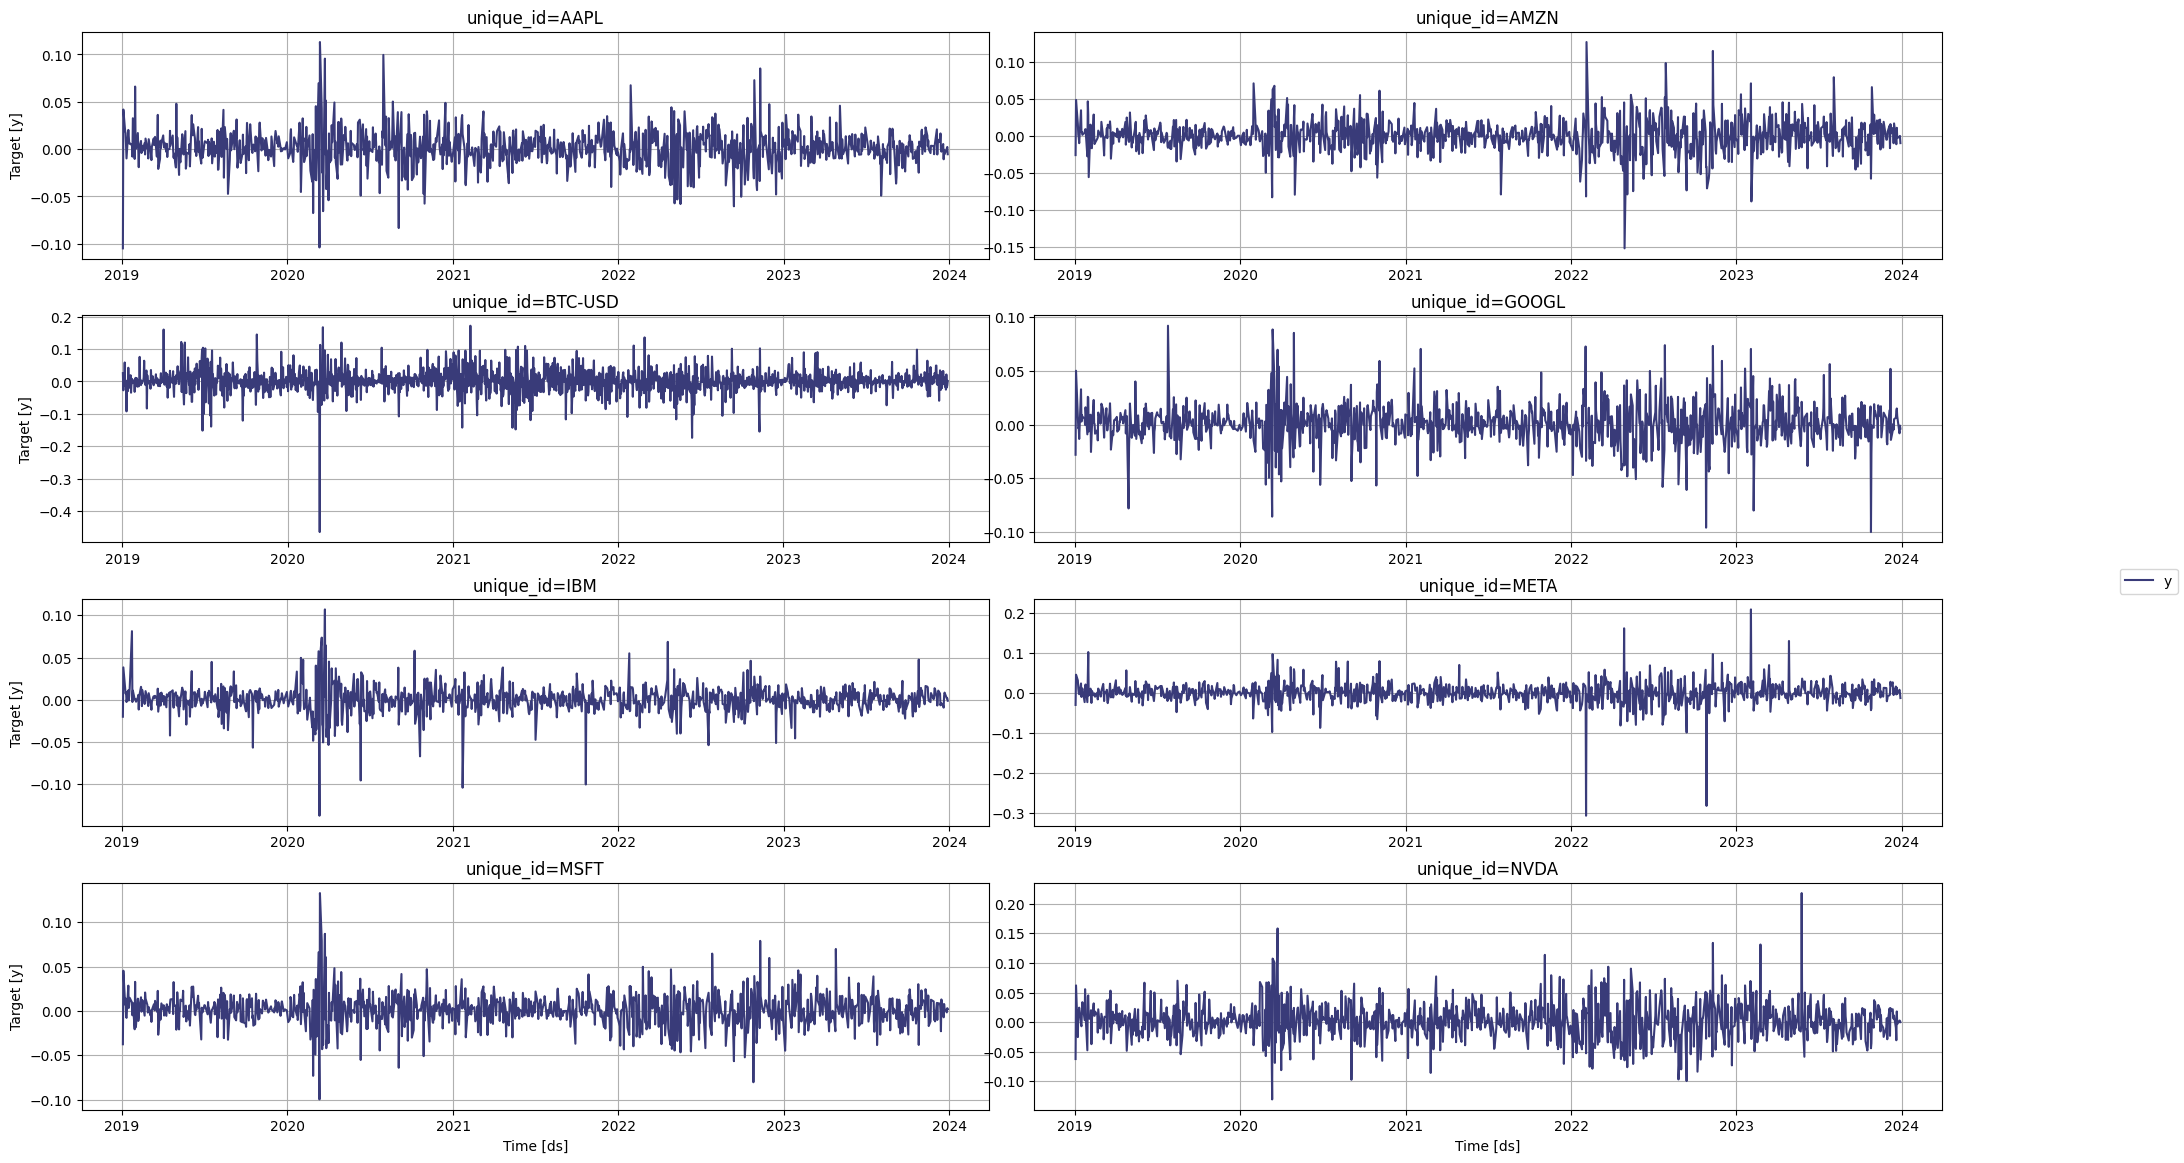

In [3]:
StatsForecast.plot(Y_df)

In [4]:
season_length = 7
horizon = 28

models = [
    AutoARIMA(season_length=season_length),
    SeasonalNaive(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [5]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,AutoARIMA,SeasonalNaive
unique_id,,,
AAPL,2023-12-30,6.990859e-04,0.005346
AAPL,2023-12-31,-3.532434e-04,-0.010772
AAPL,2024-01-01,-3.195063e-05,-0.000770
AAPL,2024-01-02,-1.853933e-04,-0.005563
AAPL,2024-01-03,-2.076127e-07,0.000518


In [6]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=5, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,
AAPL,2023-04-18,2023-04-14,0.007477,-0.000172,-0.033955,0.033612,-0.003255,-0.097605,0.091095
AAPL,2023-04-19,2023-04-14,0.006944,0.000000,-0.033991,0.033991,-0.011355,-0.105705,0.082995
AAPL,2023-04-20,2023-04-14,-0.005864,0.000000,-0.033991,0.033991,0.005481,-0.088869,0.099831
AAPL,2023-04-21,2023-04-14,-0.009829,0.000000,-0.033991,0.033991,-0.007620,-0.101970,0.086730
AAPL,2023-04-25,2023-04-14,-0.009481,0.000000,-0.033991,0.033991,-0.004363,-0.098713,0.089987


In [7]:
cv_df.tail()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,
NVDA,2023-12-21,2023-11-07,0.018105,0.0,-0.052994,0.052994,-0.009299,-0.155188,0.136589
NVDA,2023-12-22,2023-11-07,-0.003271,0.0,-0.052994,0.052994,0.037186,-0.108702,0.183075
NVDA,2023-12-27,2023-11-07,0.002796,0.0,-0.052994,0.052994,0.027521,-0.118368,0.173409
NVDA,2023-12-28,2023-11-07,0.002123,0.0,-0.052994,0.052994,0.033875,-0.112014,0.179764
NVDA,2023-12-29,2023-11-07,0.000000,0.0,-0.052994,0.052994,0.004449,-0.141440,0.150338


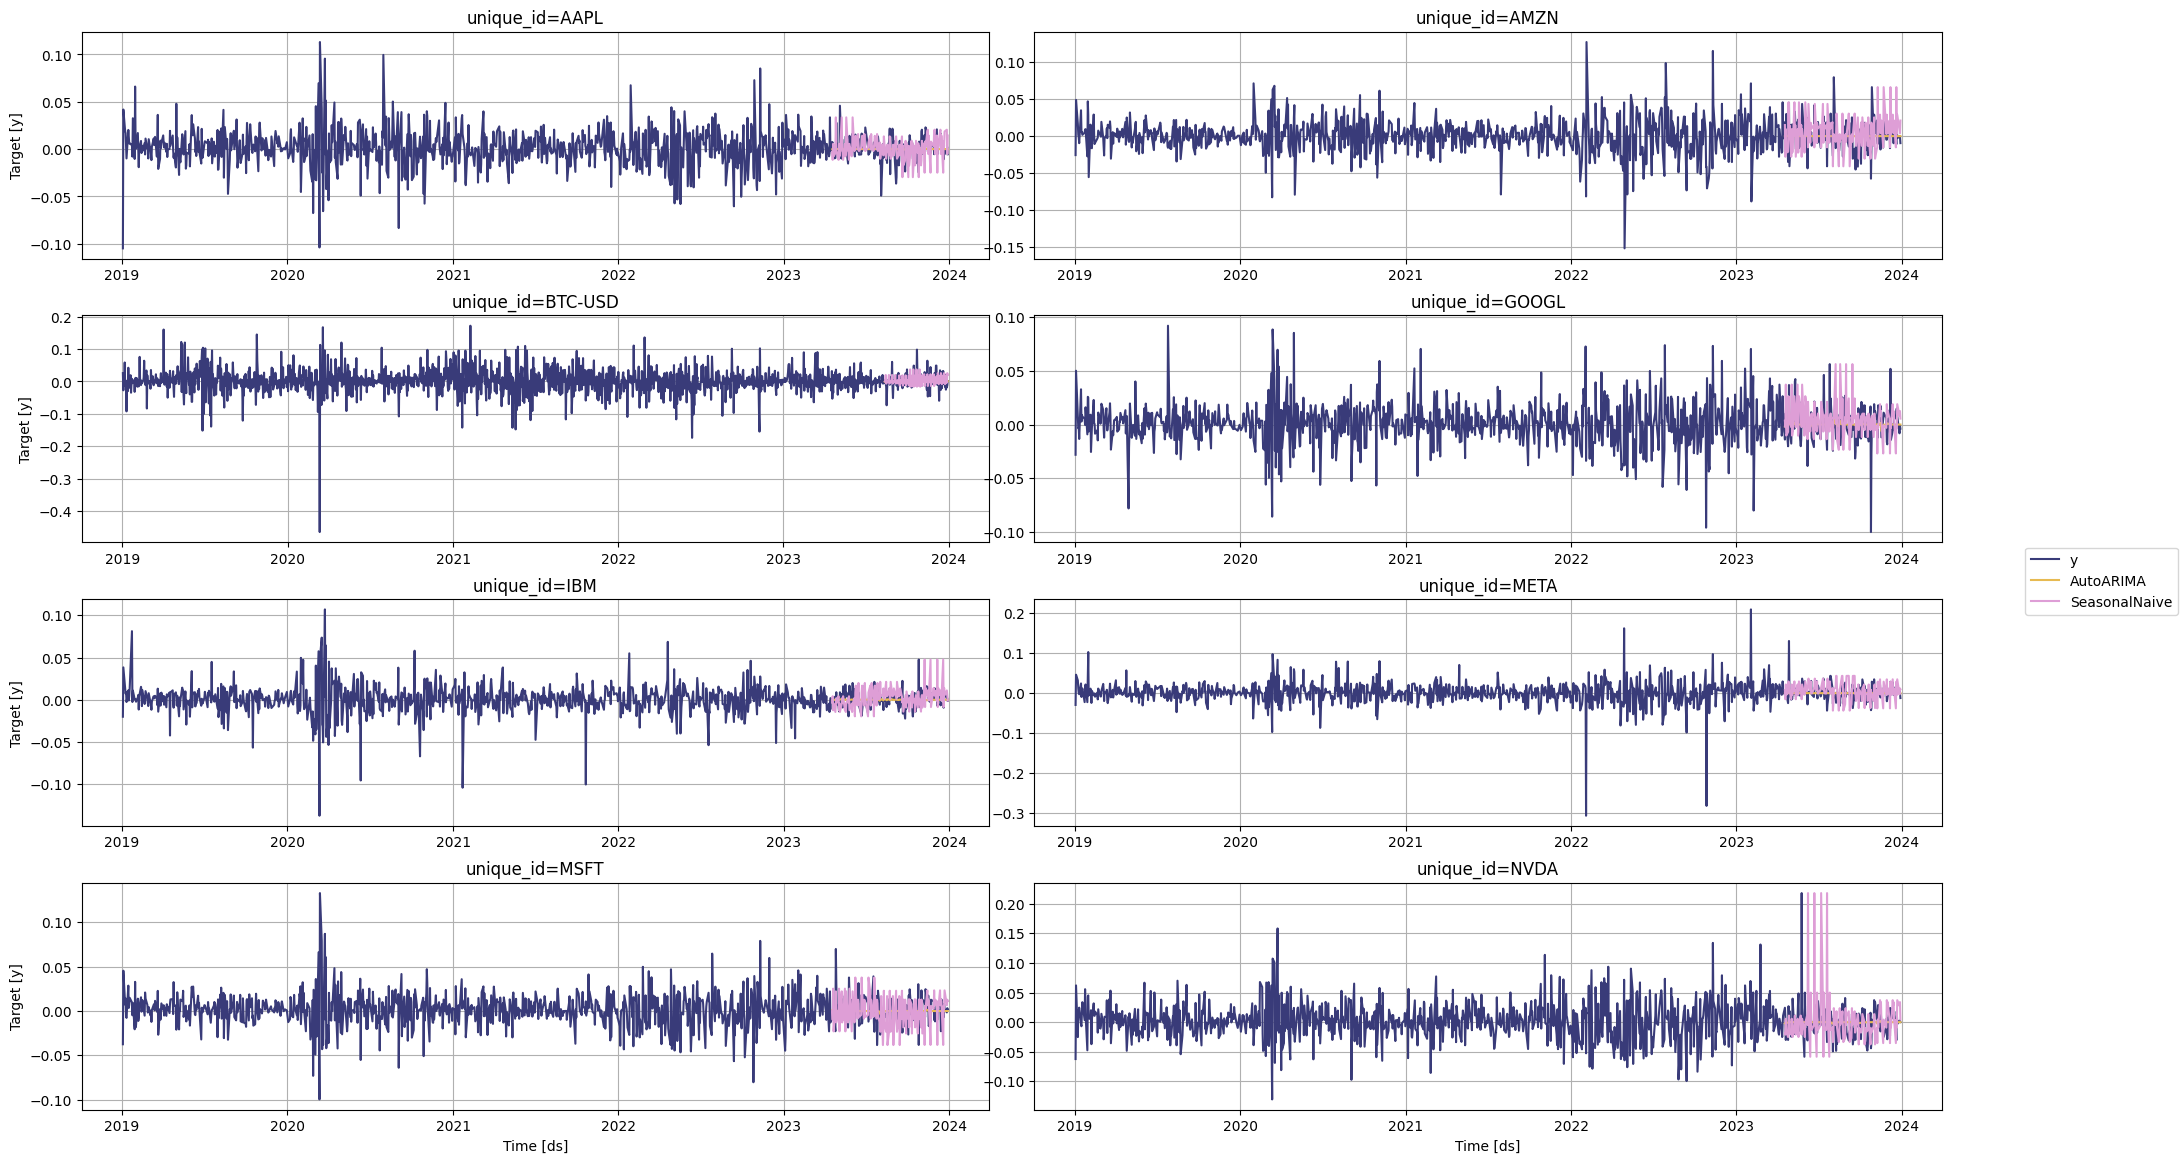

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [9]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [10]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [11]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [12]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [13]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-09 15:20:03,239 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ba5bb4a7ded15b2a86982d3de7d3b17b initialized by task ('shuffle-transfer-ba5bb4a7ded15b2a86982d3de7d3b17b', 3) executed on worker tcp://127.0.0.1:57258
2024-07-09 15:20:05,932 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ba5bb4a7ded15b2a86982d3de7d3b17b deactivated due to stimulus 'task-finished-1720531205.920152'


,unique_id,cutoff,metric,AutoARIMA,SeasonalNaive
0,AAPL,2023-04-14,mse,0.000166,0.000393
1,AAPL,2023-04-14,mae,0.008898,0.01524
2,AAPL,2023-04-14,smape,192.857147,158.036453
3,AMZN,2023-06-06,mse,0.000348,0.000845
4,AMZN,2023-06-06,mae,0.013773,0.024829


In [14]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

AutoARIMA  SeasonalNaive
cutoff     metric                           
2023-04-14 mae       0.014832       0.020489
           mse       0.000644       0.000947
           smape   191.755997     147.125641
2023-06-06 mae       0.013537       0.023841
           mse       0.000322        0.00168
           smape   196.359238     144.476532
2023-07-28 mae       0.011664       0.019374
           mse       0.000266       0.000661
           smape   189.949295       138.8414
2023-08-12 mae       0.012652       0.013905
           mse       0.000492       0.000449
           smape   174.306793     157.704697
2023-09-09 mae       0.010908       0.012932
           mse       0.000222       0.000288
           smape   181.975967     162.350983
2023-09-19 mae       0.014833       0.019863
           mse       0.000398       0.000625
           smape   193.081787     152.475983
2023-10-07 mae       0.014417       0.020215
           mse       0.000575       0.000948
           smape   186.016556     132.969666
2023-11-04 mae       0.016029       0.018279
           mse       0.000527       0.000484
           smape   179.040451     152.008469
2023-11-07 mae       0.009581         0.0176
           mse       0.000151       0.000535
           smape   194.418106     139.025803
2023-12-02 mae       0.018068       0.023599
           mse       0.000546       0.000768
           smape    182.36348     163.039001

In [15]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

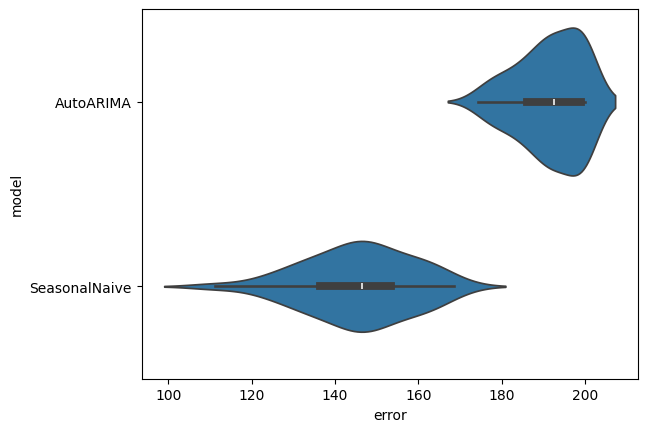

In [16]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

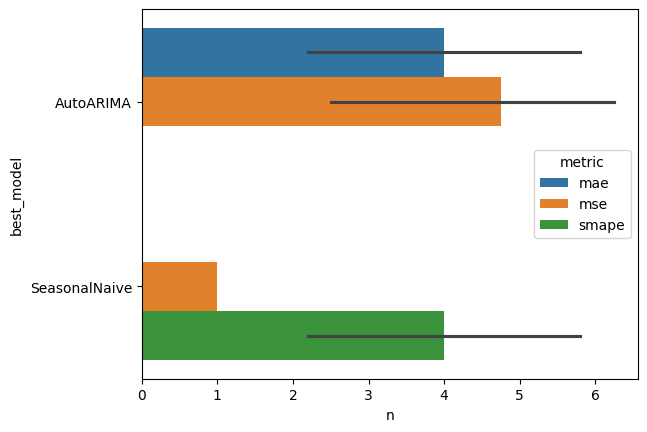

In [17]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')